In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

# PyTorch libraries and modules
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchvision import transforms

In [2]:
class PantheraDataset:
    def __init__(self, csv_file, root_dir, dataType, transform=None):
        dataset = pd.read_csv(csv_file)
        dataset = dataset.loc[dataset['Type'] == dataType]

        # Update files name in the correct format
        dataset['Photo'] = dataset['Photo'].map(lambda id: '{:08}'.format(id))
        dataset['Photo'] = dataset['Photo'].astype(str)

        nbrImg = len(dataset)
        
        dataset = dataset.reset_index(drop=True) 
        
        self.data = dataset
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_path = self.root_dir + str(self.data.loc[idx, 'Photo']) + '.jpg'
        image = imread(image_path, as_gray=True)
    
        label = self.data.loc[idx, 'Animal'].astype(np.int64)
        sample={'image': image, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [3]:
class Resize(object):
    """Resize the image in a sample to a given size.

    Args:
        output_size (int): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        img = resize(image, (self.output_size, self.output_size))

        return {'image': img, 'label': label}

In [4]:
class Normalize(object):
    """Normalize the image.

    Args:
        output_size (int): Desired output size.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        img = image/255.0

        return {'image': img, 'label': label}

In [5]:
class ToTensor(object):
    """Transform data into tensor."""

    def __init__(self):
        self = self
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        image = image.reshape(1, len(image), len(image))
        img = torch.from_numpy(image).float()
        label = torch.from_numpy(np.array(label))

        return {'image': img, 'label': label}

In [6]:
transform = transforms.Compose([
    # resize
    Resize(224),
    # normalize
    Normalize(0, 1),
    # to-tensor
    ToTensor()
])

In [7]:
dataset_train = PantheraDataset('./panthera_dataset/list_photo_prep.csv', './panthera_dataset/img/', 'train', transform)
dataset_test = PantheraDataset('./panthera_dataset/list_photo_prep.csv', './panthera_dataset/img/', 'test', transform)

In [8]:
print(dataset_test[8]['label'].shape)

torch.Size([])


In [9]:
dataset_test[0]

{'image': tensor([[[0.0022, 0.0022, 0.0022,  ..., 0.0036, 0.0036, 0.0036],
          [0.0022, 0.0021, 0.0021,  ..., 0.0036, 0.0035, 0.0035],
          [0.0020, 0.0019, 0.0019,  ..., 0.0035, 0.0036, 0.0037],
          ...,
          [0.0027, 0.0024, 0.0025,  ..., 0.0039, 0.0039, 0.0039],
          [0.0027, 0.0019, 0.0018,  ..., 0.0039, 0.0039, 0.0039],
          [0.0027, 0.0018, 0.0018,  ..., 0.0039, 0.0039, 0.0039]]]),
 'label': tensor(0)}

In [10]:
train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset_test, batch_size=4, shuffle=True, num_workers=0)

In [11]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(12544, 2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [12]:
# defining the model
model = Net().float()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=12544, out_features=2, bias=True)
  )
)


In [13]:
def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=100, device='cpu'):
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))
    
    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []
    
    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch['image'].to(device)
            y    = batch['label'].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch['image'].to(device)
            y    = batch['label'].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

In [14]:
# defining the number of epochs
n_epochs = 5

# training the model
history = train(
    model = model,
    optimizer = optimizer,
    loss_fn = CrossEntropyLoss(),
    train_dl = train_loader,
    val_dl = test_loader, 
    epochs = n_epochs)

train() called: model=Net, opt=Adam(lr=0.070000), epochs=5, device=cpu

Epoch   1/  5, train loss: 73.89, train acc:  0.72, val loss:  1.74, val acc:  0.94
Epoch   2/  5, train loss:  4.27, train acc:  0.59, val loss:  0.83, val acc:  0.35
Epoch   3/  5, train loss:  0.71, train acc:  0.44, val loss:  0.67, val acc:  0.65
Epoch   4/  5, train loss:  0.68, train acc:  0.59, val loss:  0.65, val acc:  0.65
Epoch   5/  5, train loss:  0.69, train acc:  0.59, val loss:  0.65, val acc:  0.65

Time total:     543.98 sec
Time per epoch: 108.80 sec


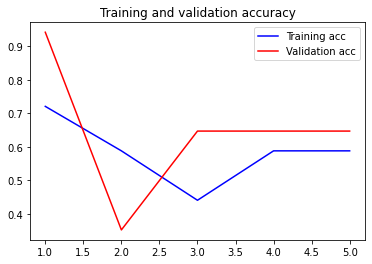

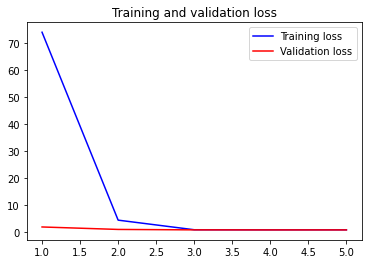

In [16]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()